# Linear Dynamical System

In [1]:
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import matplotlib.pyplot as plt
from IPython.display import HTML

import numpy as np
import jax.numpy as jnp

from extravaganza.dynamical_systems import LDS

from extravaganza.controllers import NonlinearBPC
from extravaganza.sysid import Predictor, Lifter
from extravaganza.observables import FullObservation, PartialObservation, TimeDelayedObservation
from extravaganza.controllers import LQR, HINF, BPC, GPC, RBPC
from extravaganza.rescalers import ADAM, D_ADAM, DoWG
from extravaganza.utils import ylim, render
from extravaganza.experiments import Experiment

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = 3
CONTROLLER_SEED = None
SYSID_SEED = None

INFO: Created a temporary directory at /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpyz4dyl7a
INFO: Writing /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpyz4dyl7a/_remote_module_non_scriptable.py


## System
Here, we work with a Linear Dynamical System (LDS) with various types of perturbations.

The states $\{x_t\}_{t}$ evolve with
$$x_{t+1} = A x_{t} + B u_t + w_t,$$
where $A$ and $B$ are randomly generated dynamics, $u_t$ is the input control, and $w_t$ is the output of one of the below disturbance schedules.

The costs are denoted by $f(x_t, u_t)$ and given by the below cost functions.

INFO: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


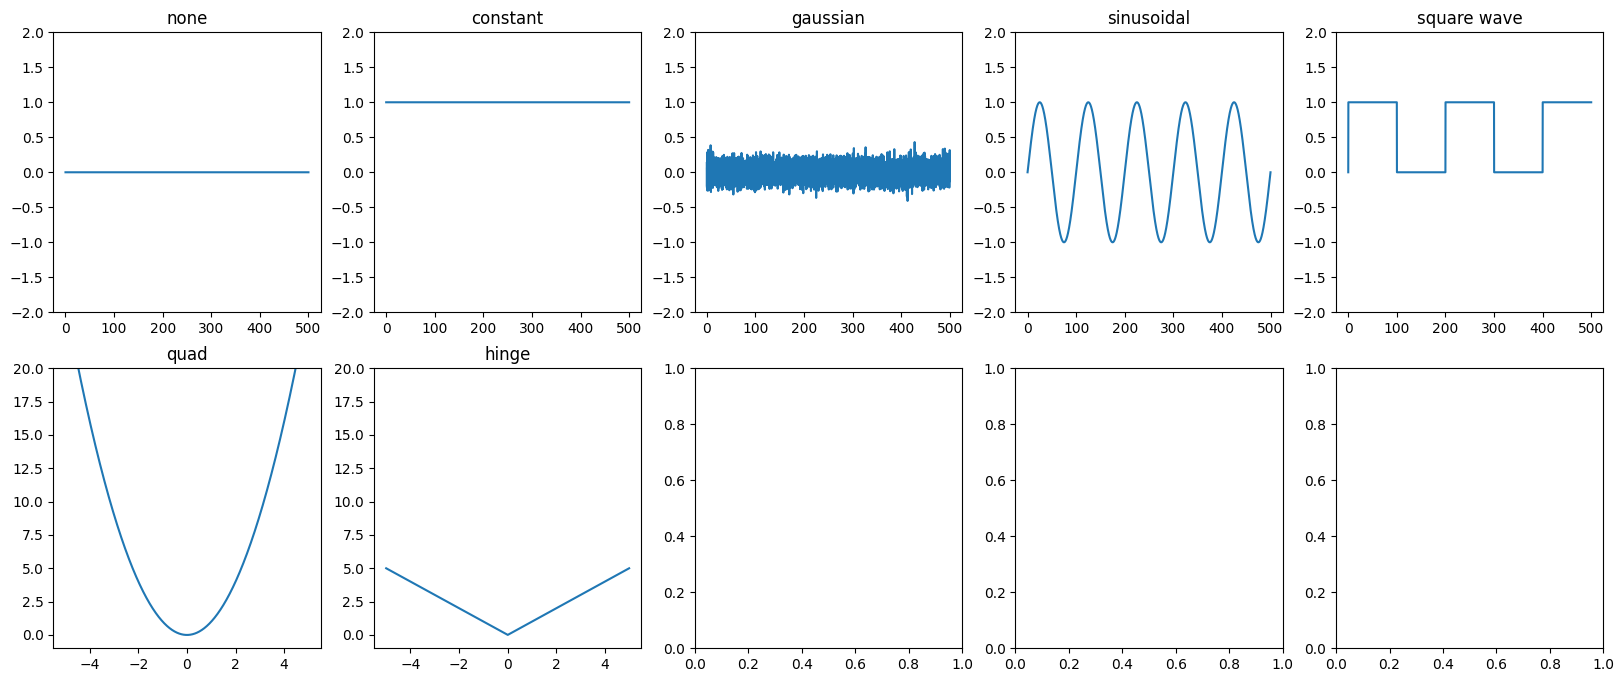

In [2]:
disturbance_fns = {'none': lambda t: 0.,
                   'constant': lambda t: 1.,
                   'gaussian': lambda t: np.random.randn() * 0.1,  # variance of 0.01
#                    'linear': lambda t: float(t),  # this one is stupid
                   'sinusoidal': lambda t: np.sin(2 * np.pi * t / 100),  # period of 100 steps
                   'square wave': lambda t: np.ceil(t / 100) % 2  # period of 40
                  }

cost_fns = {'quad': lambda x, u: jnp.dot(x, x) + jnp.dot(u, u),
            'hinge': lambda x, u: jnp.sum(jnp.abs(x)) + jnp.sum(jnp.abs(u))}

num_points = 10000
fig, ax = plt.subplots(2, len(disturbance_fns), figsize=(4 * len(disturbance_fns), 8))
for i, (k, fn) in enumerate(disturbance_fns.items()):
    xs = np.linspace(0, 500, num_points)
    ax[0, i].plot(xs, [fn(t) for t in xs])
    ax[0, i].set_ylim(-2, 2)
    ax[0, i].set_title(k)
for i, (k, fn) in enumerate(cost_fns.items()):
    xs = np.linspace(-5, 5, num_points)
    ax[1, i].plot(xs, [fn(t, 0) for t in xs])
    ax[1, i].set_ylim(-1, 20)
    ax[1, i].set_title(k)    
plt.show()

## Hyperparameters

In [3]:
from extravaganza.controllers import Controller, GPC
from extravaganza.sysid import SystemModel
from extravaganza.utils import set_seed

class Hehe(Controller):
    def __init__(self, 
             sysid: SystemModel,
             control_dim: int,
             h: int,
             T0: int,
             seed: int = None):

        set_seed(seed)
        self.h = h
        self.control_dim = control_dim
        self.T0 = T0
        self.sysid = sysid
        self.t = 1
        self.seed = seed
        pass
    
    def get_control(self, 
                    cost: float, 
                    obs: jnp.ndarray) -> jnp.ndarray:
        
         # 1. explore for sysid, otherwise continue
        self.t += 1
        if self.t < self.T0:
            control = self.sysid.explore(cost, obs)
            return control
        elif self.t == self.T0:  # from this point onward, self.sysid.A/B can be referenced
            self.sysid.end_exploration()
            A, B = self.sysid.A, self.sysid.B
            print(A.shape, B.shape)
            self.controller = GPC(A=A, B=B, H=self.h, lr_scale=0.01)
            pass
        state = self.sysid.get_state(obs)
        control = self.controller.get_control(cost, state)

        return control

In [4]:
name = 'bozo'
filename = '../logs/{}.pkl'.format(name)

def get_experiment_args():
    # --------------------------------------------------------------------------------------
    # ------------------------    EXPERIMENT HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    num_trials = 1
    T = 15000  # total timesteps
    T0 = 12000  # number of timesteps to just sysid for our methods
    reset_condition = lambda t: t % 6000 == 0  # how often to reset the system
    use_multiprocessing = False
    render_every = None

    # --------------------------------------------------------------------------------------
    # --------------------------    SYSTEM HYPERPARAMETERS    ------------------------------
    # --------------------------------------------------------------------------------------

    du = 2  # control dim
    ds = 6  # state dim
    dl = 8  # "state" dim, i.e. dim we lift to

    disturbance_type = 'none'
    cost_fn = 'quad'

    make_system = lambda : LDS(ds, du, disturbance_type, cost_fn, seed=SYSTEM_SEED)
    observable = TimeDelayedObservation(hh = 10, control_dim=du, use_states=False, use_costs=True, use_controls=True); do = observable.hh * (ds * observable.use_states + 1 * observable.use_costs + du * observable.use_controls)
#     observable = PartialObservation(obs_dim = 3, state_dim=ds, seed=SYSTEM_SEED); do = observable.obs_dim
#     observable = FullObservation(); do = ds

    # --------------------------------------------------------------------------------------
    # ------------------------    LIFT/SYSID HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    sysid_args = {
        'obs_dim': do,
        'control_dim': du,
        'initial_control': jnp.zeros(du),
        
        'max_traj_len': 20000,
        'exploration_scale': 1.5,

        'depth': 12,
        'num_epochs': 250,
        'batch_size': 1024,
        'lr': 0.001,
        
        'seed': SYSID_SEED,
    }

    # --------------------------------------------------------------------------------------
    # ------------------------    CONTROLLER HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    h = 5  # controller memory length (# of w's to use on inference)
    m_update_rescaler = lambda : ADAM(0.003, betas=(0.9, 0.999))
    m0_update_rescaler = lambda : ADAM(0.003, betas=(0.9, 0.999))
    k_update_rescaler = lambda : ADAM(0.00, betas=(0.9, 0.999))

    nonlinear_bpc_args = {
        'h': h,  
        'method': 'REINFORCE',
        'initial_scales': (0.2, 0.005, 0.),  # M, M0, K   (uses M0's scale for REINFORCE)
        'rescalers': (m_update_rescaler, m0_update_rescaler, k_update_rescaler),
        'T0': T0,
        'bounds': None,
        'initial_u': jnp.zeros(du),
        'decay_scales': False,
        'use_tanh': False,
        'seed': CONTROLLER_SEED
    }

    make_controllers = {
#         'LQR': lambda sys: LQR(sys.A, sys.B, jnp.eye(ds), sys.R, seed=CONTROLLER_SEED),
#         'HINF': lambda sys: HINF(sys.A, sys.B, jnp.eye(ds), sys.R, T=T, seed=CONTROLLER_SEED),
#         'GPC': lambda sys: GPC(sys.A, sys.B, Q=jnp.eye(ds), R=sys.R, H=h, lr_scale=0.01, decay=True, seed=CONTROLLER_SEED),
#         'BPC': lambda sys: BPC(sys.A, sys.B, Q=jnp.eye(ds), R=sys.R, H=h, lr_scale=0.01, decay=True, delta=0.001, seed=CONTROLLER_SEED),
#         'RBPC': lambda sys: RBPC(sys.A, sys.B, Q=jnp.eye(ds), R=sys.R, H=h, M=h, lr=0.01, delta=0.001, noise_sd=0.05, seed=CONTROLLER_SEED),

#         'Linear': lambda sys: NonlinearBPC(sysid=Predictor(epsilon=0, norm_fn=observable.norm_fn, **sysid_args), **nonlinear_bpc_args),
#         'Nonlinear': lambda sys: NonlinearBPC(sysid=Predictor(epsilon=0.05, norm_fn=observable.norm_fn, **sysid_args), **nonlinear_bpc_args),
        'hehe': lambda sys: Hehe(sysid=Lifter(method='nn', state_dim=dl, sysid_every=3, **sysid_args), h=h, control_dim=du, T0=T0, seed=CONTROLLER_SEED),
        'Lifted': lambda sys: NonlinearBPC(sysid=Lifter(method='nn', state_dim=dl, sysid_every=3, **sysid_args), **nonlinear_bpc_args)
    }
    experiment_args = {
        'make_system': make_system,
        'make_controllers': make_controllers,
        'observable': observable,
        'num_trials': num_trials,
        'T': T,
        'reset_condition': reset_condition,
        'reset_seed': SYSTEM_SEED,
        'use_multiprocessing': use_multiprocessing,
        'render_every': render_every,
    }
    return experiment_args

## actually run the thing :)

In [5]:
# run
experiment = Experiment(name)
stats = experiment(get_experiment_args)

INFO: (EXPERIMENT) --------------------------------------------------
INFO: (EXPERIMENT) ----------------- TRIAL 0 -----------------------
INFO: (EXPERIMENT) --------------------------------------------------

INFO: (EXPERIMENT): testing hehe
INFO: (LDS): initial state is [ 1.2463559  -0.5722423  -1.4837056   0.13737531 -1.3795713   0.31873566]
 80%|███████████████████████████████████████████████▏           | 11993/15000 [00:38<00:10, 292.56it/s, control=[-0.5097505   0.22691804], cost=7.56]INFO: (LIFTER): ending sysid phase at step 11998
INFO: training!
INFO: mean loss for past 25 epochs was 0.143124520778656
INFO: mean loss for past 25 epochs was 0.25026233941316606
INFO: mean loss for past 25 epochs was 0.40049148857593536
 80%|███████████████████████████████████████████████▏           | 11993/15000 [00:50<00:10, 292.56it/s, control=[-0.5097505   0.22691804], cost=7.56]INFO: mean loss for past 25 epochs was 0.11894052892923355
INFO: mean loss for past 25 epochs was 0.106691621243953

|A| 3.5167970657348633
|A-BK| 1.0086921453475952
|B| 0.015637904
(8, 8) (8, 2)


 80%|███████████████████████████████████████▉          | 11999/15000 [01:17<25:45,  1.94it/s, control=[ 1.6771017e+33 -3.3868455e+33], cost=1.08e+33]ERROR: (EXPERIMENT): state [ 1.5011399e+16  1.8448935e+16  1.3076489e+16  4.2006818e+15
 -1.5152331e+16 -3.9229716e+15] or cost 1.0808773252560771e+33 diverged
 80%|███████████████████████████████████████▏         | 12001/15000 [01:17<00:19, 155.80it/s, control=[ 1.6771017e+33 -3.3868455e+33], cost=1.08e+33]
INFO: 
INFO: (EXPERIMENT): testing Lifted
INFO: (LDS): initial state is [ 1.2463559  -0.5722423  -1.4837056   0.13737531 -1.3795713   0.31873566]


6.5839953 14.306105
54054.93 260835.78
34964484000000.0 168716800000000.0
inf inf


 43%|██████████████████████████▉                                   | 6507/15000 [00:19<00:25, 328.50it/s, control=[0.2584315  0.62989867], cost=22.5]

KeyboardInterrupt



In [ ]:
# # save args and stats!  --  note that to save the args, we actually save the `get_args` function. we can print the 
# #                           source code later to see the hyperparameters we chose
# experiment.save(filename)

## Visualization
We keep track of the useful information through `Stats` objects, which can `register()` a variable to keep track of (which it does via calls to `update()`) and which can be aggregated via `Stats.aggregate()` for mean and variance statistics. 

We define below a plotting arrangement that plots all the desired quantities from both the system and controller.

In [ ]:
def plot_lds(experiment: Experiment):
    assert experiment.stats is not None, 'cannot plot the results of an experiment that hasnt been run'
    all_stats = experiment.stats
    
    # clear plot and calc nrows
    plt.clf()
    n = 5
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 6 * nrows))

    # plot stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            logging.warning('{} had no stats'.format(method))
            continue
        stats.plot(ax[0, 0], 'xs', label=method)
#         stats.plot(ax[0, 1], 'ws', label=method)
        stats.plot(ax[3, 1], 'us', label=method)
        if 'costs' in stats:
            stats.plot(ax[1, 0], 'avg costs', label=method)
            stats.plot(ax[1, 1], 'costs', label=method)
        else:
            stats.plot(ax[1, 0], 'avg fs', label=method)
            stats.plot(ax[1, 1], 'fs', label=method)
    
        stats.plot(ax[2, 0], '||A||_op', label=method)
        stats.plot(ax[2, 1], '||B||_F', label=method)
        stats.plot(ax[3, 0], '||A-BK||_op', label=method)
        stats.plot(ax[4, 0], 'state norms', label=method)
        i_ax = ax[n + i // 2, i % 2]
        stats.plot(ax[0, 1], 'disturbance norms', label=method)
        stats.plot(i_ax, 'K @ state', label='K @ state')
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w')
        stats.plot(i_ax, 'M0', label='M0')
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('position'); _ax.legend()
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend()
    _ax = ax[1, 0]; _ax.set_title('avg costs'); _ax.legend()
    _ax = ax[1, 1]; _ax.set_title('costs'); _ax.legend()
    
    _ax = ax[2, 0]; _ax.set_title('||A||_op'); _ax.legend()
    _ax = ax[2, 1]; _ax.set_title('||B||_F'); _ax.legend()
    
    _ax = ax[3, 0]; _ax.set_title('||A-BK||_op'); _ax.legend()
    _ax = ax[3, 1]; _ax.set_title('controls'); _ax.legend()
    
    _ax = ax[4, 0]; _ax.set_title('state norms'); _ax.legend()
    pass

### Plot

In [ ]:
# plot
# from copy import deepcopy
# e = deepcopy(experiment)
# e.stats = {k: s[5100:] for k, s in e.stats.items() if k not in ['No Lift', 'RBPC']}
plot_lds(experiment)

### Dynamic Plot

In [ ]:
# dynamic plot
anim = render(experiment, 'disturbance norms', 'fs', sliderkey='disturbance norms', save_path=None, duration=5, fps=30)
vid = anim.to_html5_video()
HTML(vid)